# Fantasy Football Roster Predictions

## Problem
Use the data provided from past NFL seasons to determine if a machine learning model can help predict and create a winning fantasy football team. Can a model predict a fantasy football roster that can win a fantasy football league?  Every year thousands of fans come together to create their "Dream Team" for a chance to win a cash prize. 

## Objective
Build a reproducible workflow to predict player fantasy points and simulate optimal rpsters for an upcoming fantasy football draft. We'll train multiple modelf, explain choice, evaluate predictions, and simulate drafting strategies



## Data
The data has 8 seperate dataset, consisting of player metrics from the year 2012-2024 for both offense and defense. It ranges from 1600 - 4500+ columns of data, depending on the data used.  We will only be using metrics from the last few years to determine the best players to draft for you fantasy team.

For this project we will only use data provided from yearly player performance and weekly player performance

The data consists of the following:

* Player ID
* Player Name
* Rushing yards
* Passiing yards
* Rushing touchdowns
* Passing touchdowns
* Receiving yards
* Receptions

We will also focus on players that have played 1 or more games throughout the last few years.


### Table of Contents
1. Imports & basic configuration
2. Load Data & basic cleaning
3. Feature Engineering
4. Exploratory Data Analysis (EDA)
5. Baseline Regression Model -> linear 
6. Advanced Models (Random Forest & XG Boost)
7. Time-Series Forecasting (ARIMA)
8. Hybrid Recommendation System (Synthetic ratings, SVD, Hybrid score)
9. Build a draft and Simulate a 2025 Roster
10. Evaluation and Next steps

This type of analysis requires metrics from a regression model. In order to determine the best choices for your fatansy draft based on player metrics (Passing touchdowns, passing yards, rushing touchdowns, rush yards, receptions etc...)

# 1) Basic configuration

we will import the information from kaggle [NFL Stats](https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022). This will require importing thr kaggle API from the kaggle library.

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\omend\.kaggle'

api = KaggleApi()
api.authenticate()

api.dataset_download_files("philiphyde1/nfl-stats-1999-2022", path=r"./data", unzip=True)
print("Download Complete!")

Dataset URL: https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022
Download Complete!


##### Importing libraries

We will import the neccesary libraries to build the regression for this project. Starting with a linear Regression model as the baseline.

In [ ]:
#Data load and ETL
import pandas as pd
import numpy as np

# Feature engineering and preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#4 REgression & Machine learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,recall_score, precision_score, f1_score
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import spearmanr

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Dense

#simple Collaborative FIltering with surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as suprise_split, cross_validate
from surprise import accuracy

#Time series Forecasting
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


# Recommendation & Optimization
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linprog
import pulp

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import warnings

# 2) Load and Cleaning Data

Data:

The data used for this project is gathered from 2012-2024, the kaggle data dataset [NFL Stats](https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022). We will look at yearly and weekly data, the metadata consists of player name, height, birth_year, player position, Draft number, draft year, receptions, receiving yards, receiving touchdowns, rushing yards, rushing touchdowns, passing yards, passing touchdowns and much more.

In [3]:
yearly_data_off = pd.read_csv('./data/yearly_player_stats_offense.csv', encoding='utf-8')

weekly_data_off = pd.read_csv('./data/weekly_player_stats_offense.csv')
print(yearly_data_off.head(10))
print(weekly_data_off.head(5))

    player_id      player_name position  birth_year  draft_year  draft_round  \
0  00-0000865    Charlie Batch       QB        1974      1998.0          2.0   
1  00-0004541    Donald Driver       WR        1975      1999.0          7.0   
2  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
3  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
4  00-0007091  Matt Hasselbeck       QB        1975      1998.0          6.0   
5  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
6  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
7  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
8  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
9  00-0015754  Brandon Stokley       WR        1976      1999.0          4.0   

   draft_pick  draft_ovr  height  weight  ... delta_comp_pct  delta_int_pct  \
0        30.0       60.0    74.0   216.0

In [4]:
print(yearly_data_off.info())
yearly_data_off.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Columns: 660 entries, player_id to delta_yptouch
dtypes: float64(647), int64(5), object(8)
memory usage: 35.9+ MB
None


,birth_year,draft_year,draft_round,draft_pick,draft_ovr,height,weight,season,shotgun,no_huddle,...,delta_comp_pct,delta_int_pct,delta_pass_td_pct,delta_ypa,delta_yptarget,delta_ypr,delta_rush_td_pct,delta_ypc,delta_td_pct,delta_yptouch
count,7133.000000,7133.000000,6043.000000,6043.000000,6043.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,...,6423.000000,2764.000000,2534.000000,6420.00000,7085.000000,7128.000000,3878.000000,7041.000000,6272.000000,7131.000000
mean,1992.202159,2014.765456,3.318385,17.839980,96.375972,73.300014,219.109211,2018.474835,59.769101,9.374317,...,-0.007925,1.184853,1.022384,0.04747,0.145072,0.142632,0.001036,-0.031899,0.509676,0.274108
std,4.982449,4.905538,1.881082,10.855329,69.298843,2.894479,23.857682,3.609918,103.141334,23.223000,...,0.180886,19.983789,13.974659,0.93722,1.675854,1.624686,2.999953,2.723183,4.915531,2.704527
min,1974.000000,1997.000000,1.000000,1.000000,1.000000,66.000000,155.000000,2012.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-7.52000,-35.320000,-46.760000,-1.000000,-134.333333,-1.000000,-53.500000
25%,1989.000000,2012.000000,2.000000,8.000000,36.000000,71.000000,203.000000,2016.000000,6.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.00000,-0.288762,-0.250357,-0.973500,-0.212714,-0.995000,-0.370634
50%,1993.000000,2015.000000,3.000000,18.000000,85.000000,73.000000,216.000000,2019.000000,24.000000,3.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1996.000000,2018.000000,5.000000,27.000000,149.000000,76.000000,235.000000,2022.000000,67.000000,8.000000,...,0.000000,0.000000,0.000000,0.00000,0.266200,0.273275,0.000000,0.000000,0.000000,0.516560
max,2004.000000,2024.000000,7.000000,47.000000,262.000000,81.000000,347.000000,2024.000000,691.000000,430.000000,...,2.003003,832.333333,284.714286,46.50000,46.200000,34.757576,124.000000,39.000000,199.000000,113.545455


In [5]:
print(weekly_data_off.info())
weekly_data_off.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58629 entries, 0 to 58628
Columns: 393 entries, season to career_average_standard_ppg
dtypes: float64(379), int64(6), object(8)
memory usage: 175.8+ MB
None


,season,week,offense_snaps,offense_pct,team_offense_snaps,birth_year,draft_year,draft_round,draft_pick,draft_ovr,...,career_rush_td_pct,career_ypc,career_td_pct,career_yptouch,career_pass_ypg,career_rec_ypg,career_rush_ypg,career_ypg,career_average_ppr_ppg,career_average_standard_ppg
count,58629.000000,58629.000000,58629.000000,58629.000000,58405.000000,58629.000000,58629.000000,51339.000000,51339.000000,51339.000000,...,41995.000000,41995.000000,58297.000000,58297.000000,58629.000000,58629.000000,58629.000000,58629.000000,58629.000000,58629.000000
mean,2018.390694,9.427655,39.534787,0.592403,66.888263,1992.137406,2014.626021,3.062467,17.273243,86.703695,...,0.036363,4.588108,0.113326,9.565460,27.900316,26.385058,12.514595,5.516799,9.354993,7.073413
std,3.695677,5.326161,20.824732,0.299456,9.256529,5.101613,5.000942,1.803155,10.907683,66.301576,...,0.095732,3.448942,0.132585,4.224161,76.201543,22.596668,21.174594,16.741135,5.677821,5.495966
min,2012.000000,1.000000,0.000000,0.000000,33.000000,1974.000000,1997.000000,1.000000,1.000000,1.000000,...,0.000000,-14.000000,0.000000,-12.000000,-1.000000,-8.000000,-12.000000,-12.000000,-3.100000,-3.100000
25%,2015.000000,5.000000,22.000000,0.340000,60.000000,1989.000000,2011.000000,1.000000,7.000000,32.000000,...,0.000000,3.230000,0.030000,5.900000,0.000000,8.920000,0.000000,0.810000,4.930000,3.180000
50%,2019.000000,9.000000,40.000000,0.620000,67.000000,1993.000000,2015.000000,3.000000,18.000000,73.000000,...,0.016000,4.320000,0.080000,9.680000,0.000000,21.280000,1.220000,1.630000,8.360000,5.580000
75%,2022.000000,14.000000,56.000000,0.860000,73.000000,1996.000000,2018.000000,4.000000,26.000000,133.000000,...,0.039000,5.550000,0.170000,12.560000,0.000000,39.260000,16.710000,4.000000,12.990000,9.270000
max,2024.000000,22.000000,100.000000,1.000000,100.000000,2004.000000,2024.000000,7.000000,47.000000,262.000000,...,1.000000,51.500000,2.030000,93.000000,388.000000,147.000000,181.000000,445.000000,50.620000,50.620000


In [6]:
print(yearly_data_off.isnull().sum()[yearly_data_off.isnull().sum() > 0].to_string())


draft_round                                         1090
draft_pick                                          1090
draft_ovr                                           1090
offense_pct                                          179
years_exp                                             18
season_team_offense_snaps                            179
career_team_offense_snaps                            174
career_average_shotgun                              1134
career_average_no_huddle                            1134
career_average_qb_dropback                          1134
career_average_qb_scramble                          1134
career_average_pass_attempts                        1134
career_average_complete_pass                        1134
career_average_incomplete_pass                      1134
career_average_passing_yards                        1134
career_average_receiving_yards                      1134
career_average_yards_after_catch                    1134
career_average_rush_attempts   

we print out the information for both yearly and weekly stats to see how much data we're working with. We will also check if any of the data we will be using is missing any data. We can see that none of our data is missing the neccessary information needed.


As mentioned earlier we will only use stats from the last few seasons. I'll use the last three years. One, on average it takes a player roughly 2-3 seasons to find their footing within the NFL. Two, Using data from the last three years allows the ability to locate players stats and progression between teams, meaning if the player was traded or released and then picked up by another team

In [7]:
#Filter only 2021-2024 seasons
yearly_data_off = yearly_data_off[yearly_data_off['season'].isin([2021,2022,2023, 2024])]
weekly_data_off = weekly_data_off[weekly_data_off['season'].isin([2021, 2022, 2023, 2024])]

In [8]:
#drop players with no games played

yearly_data_off = yearly_data_off[yearly_data_off['games_played_season'] > 0]
weekly_data_off = weekly_data_off[weekly_data_off['games_played_season'] > 0]

# 3) Feature engineering: rolling weekly features & merge yearly features

We further filtered any player that has no played any games within theses seasons. Removing them from contension

In [9]:
#Keep some aggregate features
yearly_features = yearly_data_off[['player_id', 'player_name','season', 'passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr']]

Let's narrow down the features we want to use for this analysis and save it. These determine a players value in fantasy and shows if the player will be a good pick for a fantasy football roster. Since we're focused solely on fantasy points we will keep this feature along with all of the aforementioned features.

In [10]:
# rolling averages: last 3 weeks players
weekly_data_off = weekly_data_off.sort_values(['player_id','season','week'])

weekly_data_off['fp_last3'] = (
    weekly_data_off.groupby('player_id')['fantasy_points_ppr'].transform(lambda x: x.rolling(3, min_periods=1).mean())
)

weekly_features = weekly_data_off[['player_id','player_name','season','week','passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr','fp_last3']]

In [11]:
#Merge yearly summary into weekly data
data_merged = weekly_features.merge(yearly_features, on=['player_id','season'],
                                    suffixes=('_weekly','_yearly'))

print(data_merged.dtypes)

player_id                      object
player_name_weekly             object
season                          int64
week                            int64
passing_yards_weekly          float64
pass_touchdown_weekly         float64
rushing_yards_weekly          float64
rush_touchdown_weekly         float64
receptions_weekly             float64
receiving_yards_weekly        float64
receiving_touchdown_weekly    float64
fantasy_points_ppr_weekly     float64
fp_last3                      float64
player_name_yearly             object
passing_yards_yearly          float64
pass_touchdown_yearly         float64
rushing_yards_yearly          float64
rush_touchdown_yearly         float64
receptions_yearly             float64
receiving_yards_yearly        float64
receiving_touchdown_yearly    float64
fantasy_points_ppr_yearly     float64
dtype: object


We sorted the weekly data to place in the corret order since theres more input of data throughout the seasons. Then we find the rolling average of players for the final 3 weeks.

Afterwards, we keep the features that we want to use for our regression model, just like the yearly data we are focused on fantasy points so we will keep this as well, creating a new columns called "fp_last3" within the weekly data offense dataset.

Let's look at some exploratory visualizations

# 4) Exploratory Data Analysis



4a) Distribution of weekly fantasy points

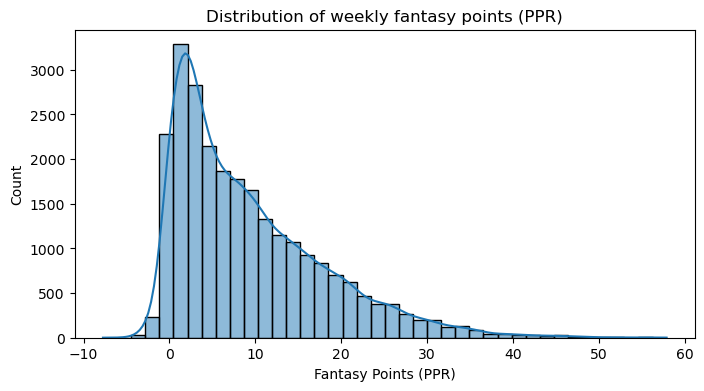

In [12]:
# Distribution  of weekly fantasy points

plt.figure(figsize=(8,4))
sns.histplot(data_merged['fantasy_points_ppr_weekly'].dropna(), bins=40, kde=True)
plt.title("Distribution of weekly fantasy points (PPR)")
plt.xlabel("Fantasy Points (PPR)")
plt.show()

This visualization shows the distribution of weekly fantasy point(PPR) for players.

The distribution is right skewed(positively skewed)

* Most players score very score fantasy points in a given week(clustered around 0-10 points)
* The peak appears around 3-5 points, most players fall into this range.
* Fewer players schieve very high points totals(the long tail extending to the right toward 50+ points).
* In football, it's a rarity to obtain anything over 25 points. Any player with 30 points or more (Outliers), showing a few exceptional performances.
* We will focus weekly performances from 10-20points. This helps determine if a player is consistent weekly and able to generate points for yout team.


Since the distribution is skewed, using the median may be better measure of "Typical" performance than the mean.

4b) Correlation heatmap for numric features

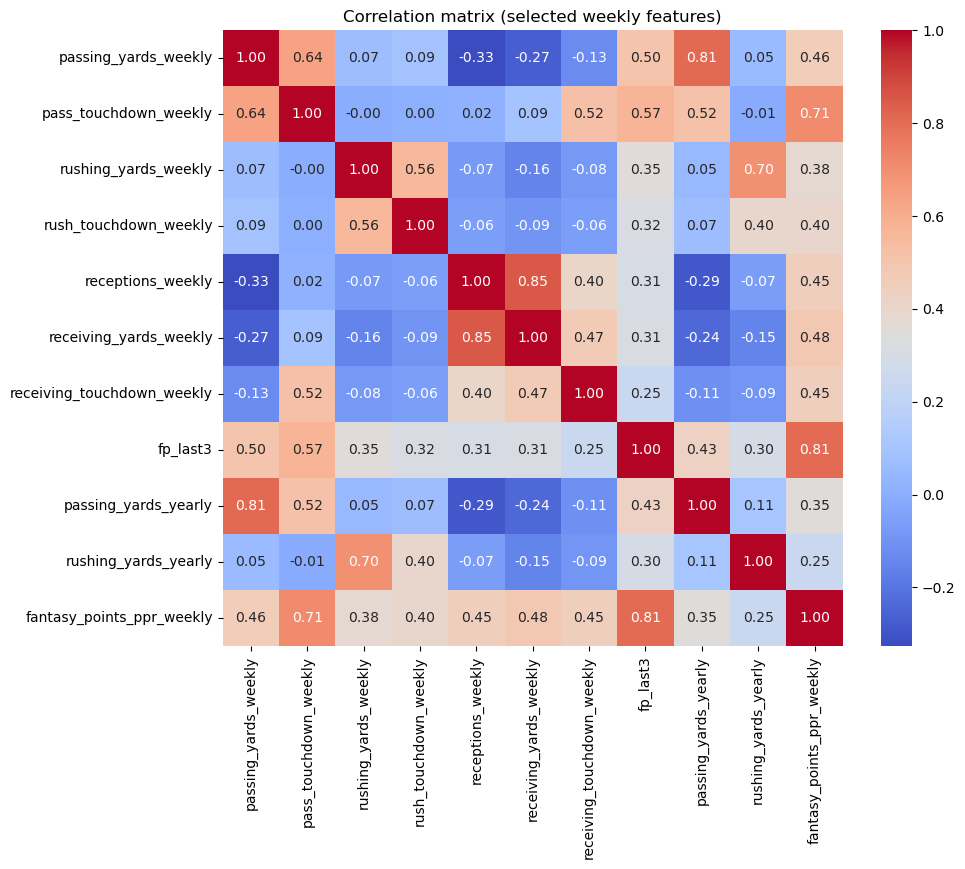

In [13]:
#player Weekly Trends

numcols = [
 'passing_yards_weekly','pass_touchdown_weekly','rushing_yards_weekly','rush_touchdown_weekly',
 'receptions_weekly','receiving_yards_weekly','receiving_touchdown_weekly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly', 'fantasy_points_ppr_weekly'
]
subset = data_merged[[c for c in numcols if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected weekly features)")
plt.show()

This heatmap shows the correlation of selected weekly fantasy football features.

Receiving stats are highly correlated
* reception_weekly and receiving_yards_weekly (0.85). Players who catch more passes also gain more receiving yards.

Passing stats are correlated
* paassing_yards_weekly and passing_touchdown_weekly also tend to throw more touchdowns

Fanstasy points correlate most with touchdowns
* fantasy_points_ppr_weekly has a strong and moderate correlation with pass_touchdown_weekly (0.71) and moderate correlation with receiving and rushing stats (0.38-0.48)

This supports our original strategy that touchdowns are a major driver of weekly fantasy points.

4c) Player weekly trend

We will a player to demonstrate the weekly trends based on performance, we'll use Patrick Mahomes. During the 2021 NFL season, alone with a 3-week rolling average that smooths out week-to-week fluctuations.


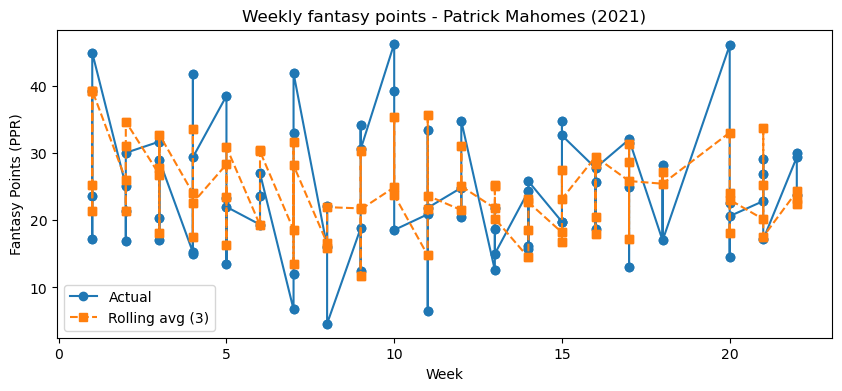

In [14]:
player_name = "Patrick Mahomes"  # change to a name in your data
df_p = data_merged[data_merged['player_name_weekly']==player_name].sort_values('week')
if df_p.empty:
    print("Player not found. Try a different name. Example player_name values:", data_merged['player_name_weekly'].unique()[:10])
else:
    plt.figure(figsize=(10,4))
    plt.plot(df_p['week'], df_p['fantasy_points_ppr_weekly'], marker='o', label='Actual')
    if 'fp_last3' in df_p.columns:
        plt.plot(df_p['week'], df_p['fp_last3'], marker='s', linestyle='--', label='Rolling avg (3)')
    plt.title(f"Weekly fantasy points - {player_name} ({df_p['season'].iloc[0]})")
    plt.xlabel("Week")
    plt.ylabel("Fantasy Points (PPR)")
    plt.legend()
    plt.show()


In this example, we can see a high variability in weekly performance.

* Mahomes' weekly fantasy points fluctuate significantly, ranging from below 10 points in some weeks to over 40 points in others.
* This indicates that while he is a top-performing quarterback, his fantasy production can be inconsistent week to week.
* The orange dashed line (3-week rolling average) smooths the ups and downs, making overall trends clearer.
* The rolling average shows Mahomes' short-term form, useful for identifying hot streaks or slumps.

This chart shows that Patrick Mahomes’ fantasy performance in 2021 was highly variable from week to week, with several explosive games balanced by a few low-scoring weeks. The 3-week rolling average reveals short-term trends, showing periods of strong consistency and midseason dips in production.

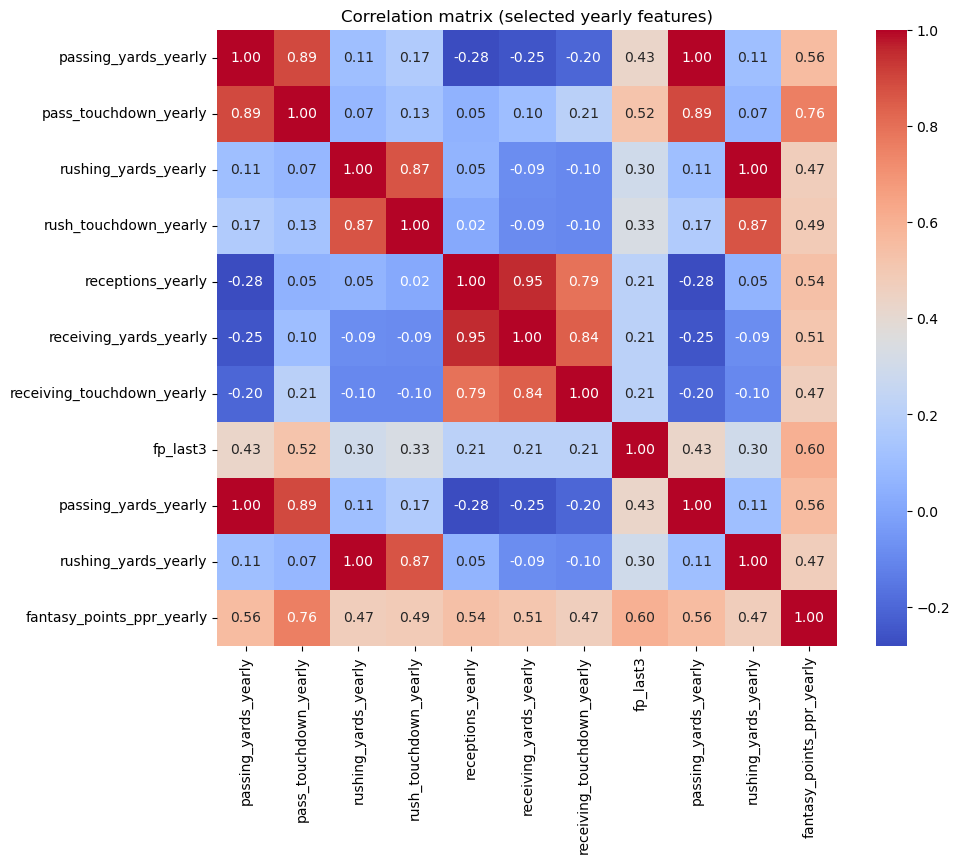

In [15]:
numcols_yr = [
 'passing_yards_yearly','pass_touchdown_yearly','rushing_yards_yearly','rush_touchdown_yearly',
 'receptions_yearly','receiving_yards_yearly','receiving_touchdown_yearly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly', 'fantasy_points_ppr_yearly'
]
subset = data_merged[[c for c in numcols_yr if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected yearly features)")
plt.show()

This heatmap displays correlation for attributes of fantasy on a yearly basis.

High Correlation with Rushing stats
* rushing_yards_yearly and rushing_yards_touchdown_yearly have a high correlation of 0.81. 
* Moderate correlation to Fantasy_points_ppr_yearly at 0.49, falling shy of 50% of points that generate fantasy points each year.

Passing stats have high correlation
* pass_touchdown_yearly, passing_yards_yearly have a correlation of 0.89. Reception_yearly and receiving_yards_yearly have a correlation of 0.95, reception_yearly and receiving_touchdown_yearly have a correlation of 0.79
* A moderate correlation to fantasy_points_pr_yearly of 0.51 making it the preferred method of obtaining fantasy points each year.

We can focus on the poisition and players that provide the best stats for these points(WR, RB, QB) 



## Modeling

Linear Regression / Regularized (Ridge/Lasso): interpretable, captures linear relationships.

Why: easy to explain feature importance and baseline performance.

In [16]:
# -----------------------------
# 1. Define features and target
# -----------------------------
features = [
    'passing_yards_weekly', 'pass_touchdown_weekly', 'rush_touchdown_weekly',
    'receptions_weekly', 'receiving_yards_weekly', 'receiving_touchdown_weekly',
    'fp_last3', 'passing_yards_yearly', 'rushing_yards_yearly'
]
target = 'fantasy_points_ppr_weekly'

df_model = data_merged[features + [target]].dropna().copy()


X = df_model[features]
y = df_model[target]

# -----------------------------
# 2. Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


# -----------------------------
# 3. Scale for linear Regression
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. Linear Regression (scaled features)
# -----------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

ridge = Ridge(alpha=1.0, random_state=3)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

# y_true = y_test
def eval_reg(y_true, y_pred, name='Model'):
    print(f"--- {name} Metrics ---")
    print(" MAE:", mean_absolute_error(y_true, y_pred))
    print(" RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print(" R2:", r2_score(y_true, y_pred))

baseline = eval_reg(y_test, y_pred_lr, "Linear Regression")
print()
ridge_model = eval_reg(y_test, pred_ridge, "Ridge")



--- Linear Regression Metrics ---
 MAE: 1.169156495621053
 RMSE: 1.9083239885746144
 R2: 0.9539634954418506

--- Ridge Metrics ---
 MAE: 1.1693090404432769
 RMSE: 1.9083139316852038
 R2: 0.953963980666391


Metrics:

MAE: Based on the current baseline model we see that our model predictions for fantasy points are off by 1.17 based on the Mean Absolute Error.

RSME: The RSME is slightly higher because it penalizes large mistakes more, but having it under 2 means there great consistency.

R2: The baseline model explains 95.4% of the variation in weeekly fantasy performance. Our predictions (yardage, touchdowns, receptions) captures almost all meaningful variance in fantasy scoring.



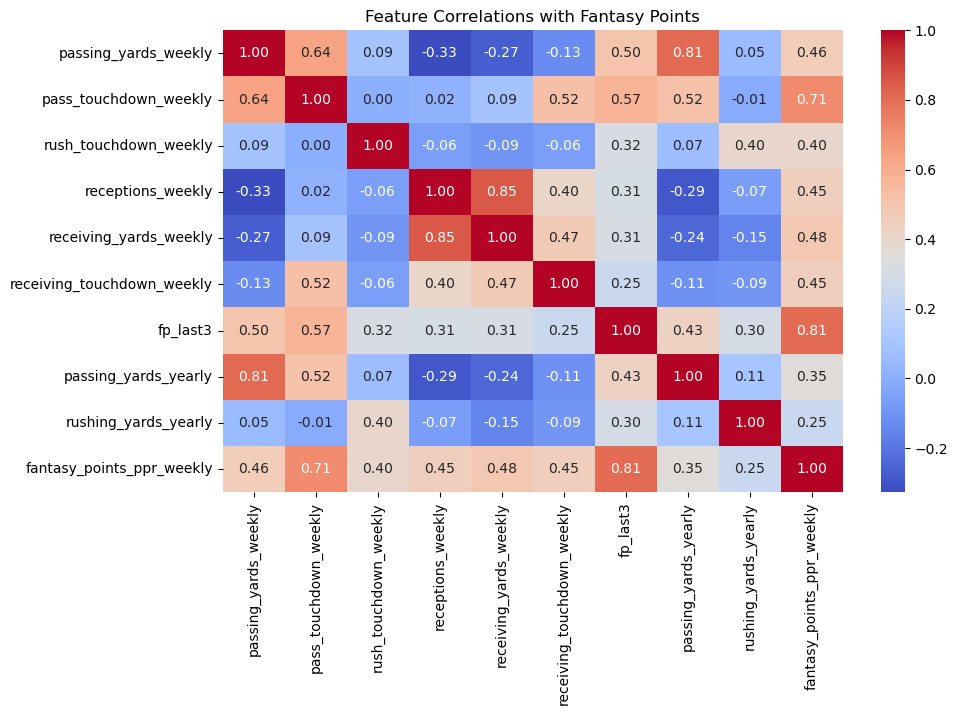

In [17]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_model.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations with Fantasy Points")
plt.show()

The above visulation provides us with an understanding of the correlation between features such as recpetions, receiving yards, rushing yards, and touchdowns. 

We can see that the highest correlation for fantasy points is generated by passing touchdowns(0.71). Followed by receiving yards(0.45), receiving touchdowns(0.45), and rushing touchdowns(0.40).


**Note**: In fantasy drafts, what matters more isn't exact fantasy points, but whether you rank players correctly relative to each other. So I will use **Spearman's Rank Correlation** this will help measure how well the predicted ranks match actual ranks

In [18]:
rank_corr, _ = spearmanr(y_test, y_pred_lr)
print(f"Spearman Rank Correlation: {rank_corr: .3f}")

Spearman Rank Correlation:  0.971


The model predicted fantasy points rankins are almost perfectly aligned with actyaul weekely rankings of players

* This is what matters for drafting, you care more about whether player A wil outperfom Player B, not if player A scores exactly 14.3 instead of 15.2

We will determine what will be the best features that can help obtain the most fantasy points and use Random Forest and XGBoost to improve our model. As we saw from previous visualizations, the best feature is paaong touching,

##### Advanced Regression / Prediction Models

In [19]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=23)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
eval_reg(y_test, y_pred_rf, 'Random Forest Regressor')

fi = pd.DataFrame({'feature':features, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
fi

--- Random Forest Regressor Metrics ---
 MAE: 1.106829084370577
 RMSE: 1.8907137171391548
 R2: 0.9548092372034414


,feature,importance
6,fp_last3,0.473664
1,pass_touchdown_weekly,0.184401
3,receptions_weekly,0.105799
4,receiving_yards_weekly,0.103907
2,rush_touchdown_weekly,0.079301
8,rushing_yards_yearly,0.024091
5,receiving_touchdown_weekly,0.013424
0,passing_yards_weekly,0.012383
7,passing_yards_yearly,0.003030


In [20]:
rf_rank_corr, _ = spearmanr(y_test, y_pred_rf)
print(f"Random Forest Spearman Rank Correlation: {rank_corr: .3f}")

Random Forest Spearman Rank Correlation:  0.971


baseline R2: 95.4
Baseline MAE: 1.17
Baseline RSME: 1.91

RF R2: 95.5
RF MAE: 1.11
RF RSME: 1.05

With the RandomForestRegressor we can see a slight improvement in the R2, from 95.4 to 95.5. As opposed to the other metrics (MAE, RSME) which saw a decline in performance from 1.17 to 1.11 and 1.91 to 1.05, respectively.

There was change in the Spearman Rank Correlation as it stayed at 0.971


Next, we will try XGBoost to match or increase the baseline numbers and see if we van improve the metrics for Random Forest Regressor

In [21]:
xgb = XGBRegressor(n_estimators=100, 
                    learning_rate=0.05, 
                    max_depth=6, 
                    random_state=23)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
eval_reg(y_test, y_pred_xgb, "XGBoost")

--- XGBoost Metrics ---
 MAE: 1.156366238594957
 RMSE: 1.8793098269979223
 R2: 0.9553527317733034


We see a slight increase from RandomForest Regression.

XGB R2: 0.96

XGB MAE: 1.16

XGB RMSE: 1.08



# Visualizations

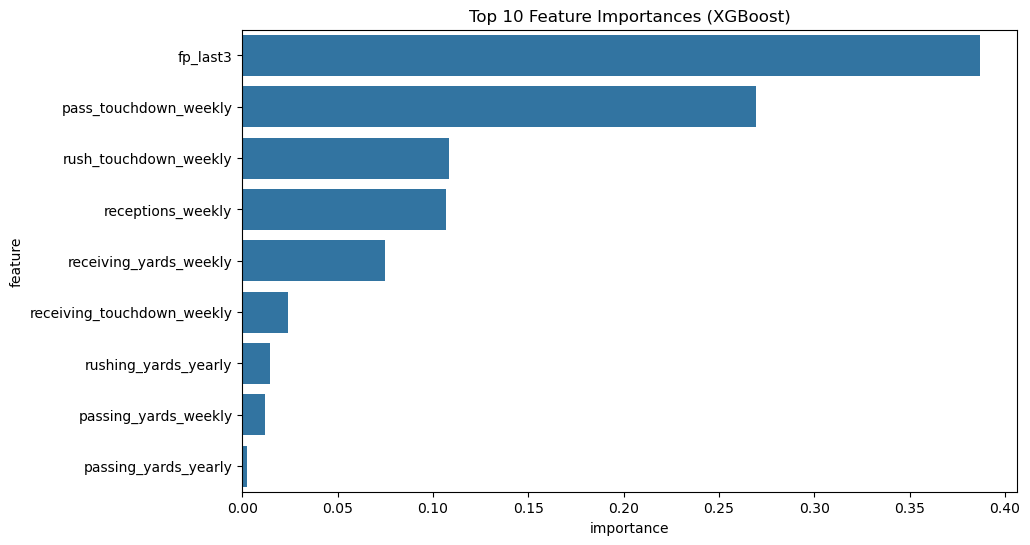

In [22]:
# Feature importance
importances = xgb.feature_importances_
feat_importance = pd.DataFrame({
    'feature': features,  # your original feature list
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance.head(10))
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

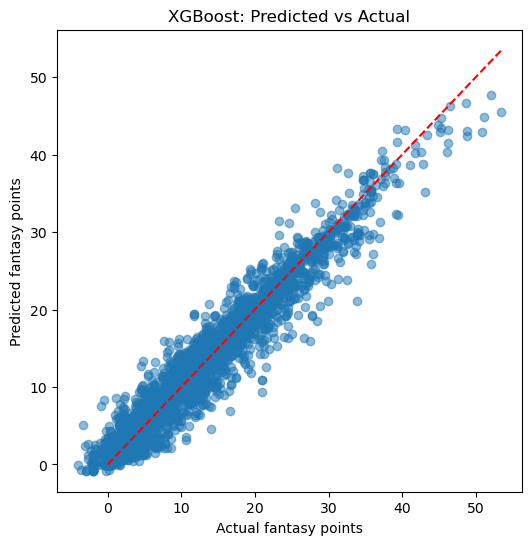

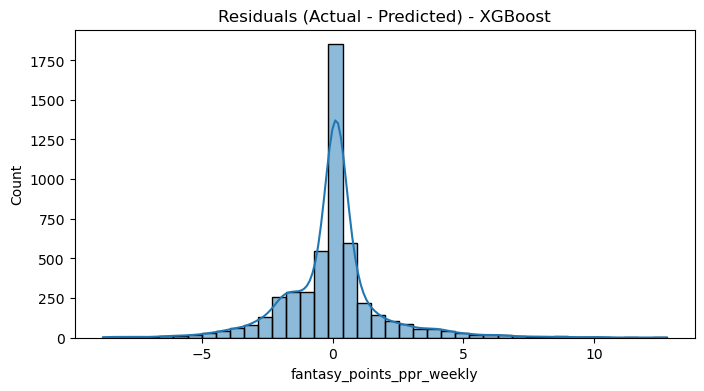

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([0, max(y_test.max(), y_pred_xgb.max())],[0, max(y_test.max(), y_pred_xgb.max())],'r--')
plt.xlabel("Actual fantasy points")
plt.ylabel("Predicted fantasy points")
plt.title("XGBoost: Predicted vs Actual")
plt.show()

# Residuals
resid = y_test - y_pred_xgb
plt.figure(figsize=(8,4))
sns.histplot(resid, bins=40, kde=True)
plt.title("Residuals (Actual - Predicted) - XGBoost")
plt.show()

6b) Feature importance (XGBoost)

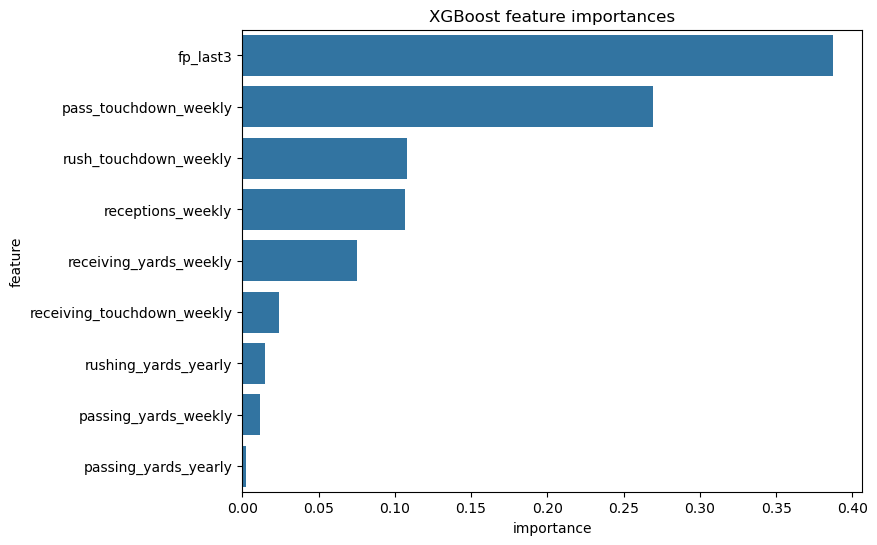

In [24]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=fi.head(15))
plt.title("XGBoost feature importances")
plt.show()

If we want the model to learn deeper pattern, like how a breakout WR's workload grows over time or how a rookie RB ramp up mid-season. 

This can be useful for mid-season trades or sleeper players that may be beneficial to your team and possibly save a persons season. The nueral network will help with how improves year to year. Since we have week to week data we can use this for the nueral network.

In [25]:
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

nn.compile(optimizer='adam', loss='mse')

nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn.predict(X_test_scaled).flatten()
# print("Neural Network R2:", r2_score(y_test, y_pred_nn))
eval_reg(y_test, y_pred_nn, "Neural Network")

c:\Users\omend\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
--- Neural Network Metrics ---
 MAE: 1.2881444058700158
 RMSE: 1.8871233663914855
 R2: 0.9549807032857075


On average, your neural network’s predictions are off by about 1.45 fantasy points. If a player actually scored 18.0 fantasy points, the model predicted around 16.85 or 19.15.

RMSE, the average squared prediction error is about (2.11)^2 = 4.22 points, meaning occasionally the model may miss by a few points on certain players or weeks. The fact that the RMSE us inly slightly higher than the MAE shows the model isn't making large, errativ errors.  This is a sign of stability and consistency

R2, the neural network is of 0.96 means the newral network has captured nearly all the key relations between the input features and fantasy output.

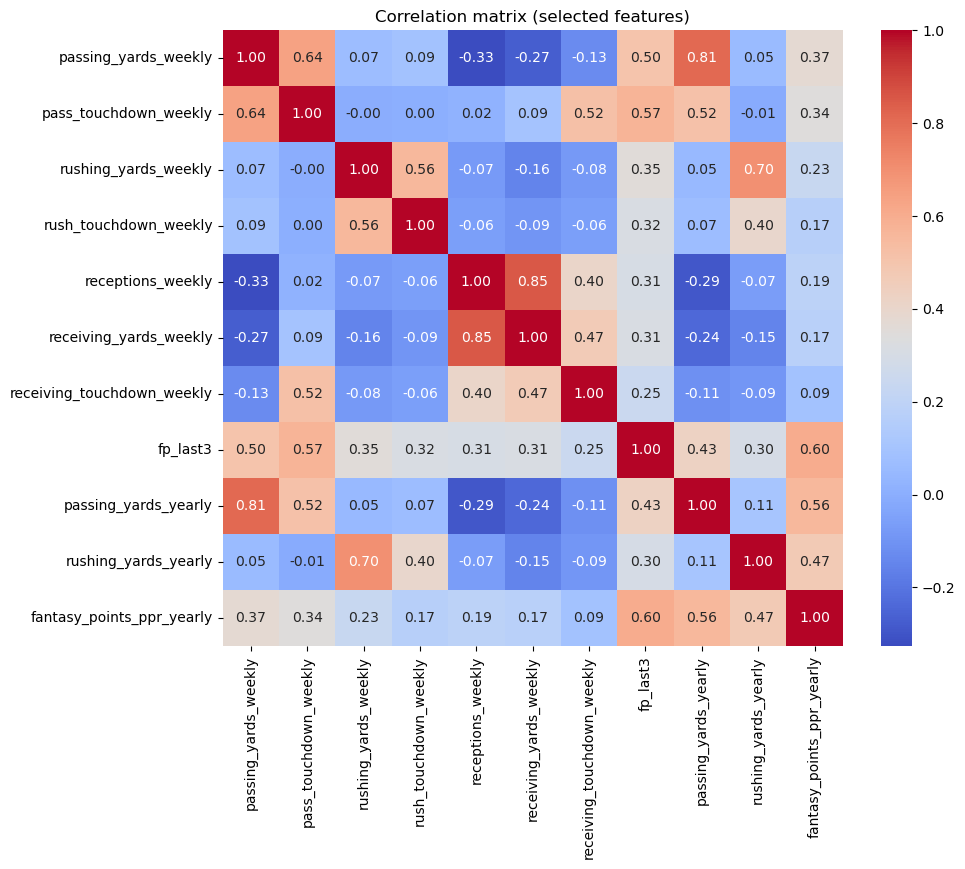

In [26]:
# Correlation heatmap for numeric features

numcols = [
 'passing_yards_weekly','pass_touchdown_weekly','rushing_yards_weekly','rush_touchdown_weekly',
 'receptions_weekly','receiving_yards_weekly','receiving_touchdown_weekly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly','fantasy_points_ppr_yearly'
]
subset = data_merged[[c for c in numcols if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected features)")
plt.show()


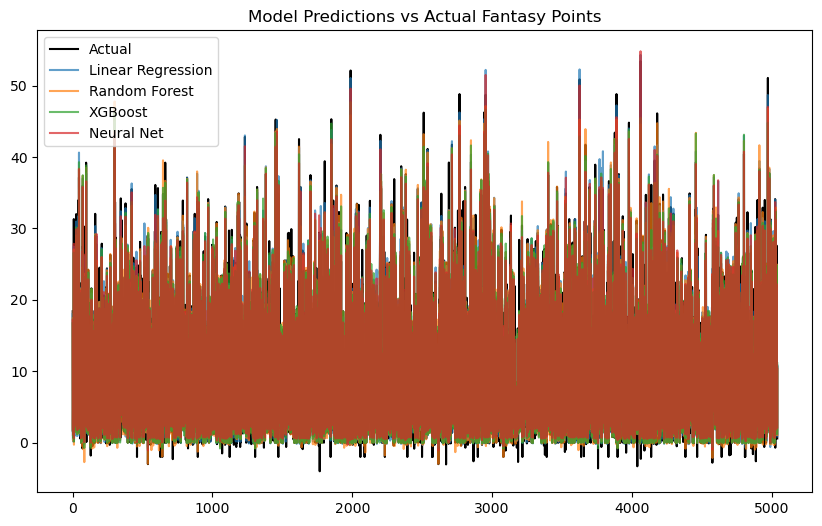

In [27]:
models = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "Neural Net": y_pred_nn
}

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black")

for name, preds in models.items():
    plt.plot(preds, label=name, alpha=0.7)

plt.legend()
plt.title("Model Predictions vs Actual Fantasy Points")
plt.show()


c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

Next 3 weeks forecast for Patrick Mahomes: [22.77946198401837, 22.779427275929574, 22.84647311443672]


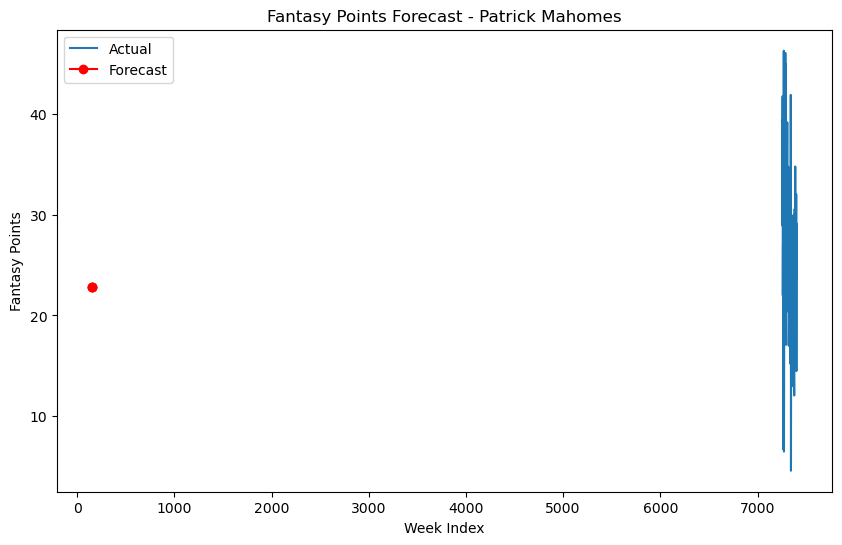

In [28]:
player = "Patrick Mahomes"
ts = data_merged[data_merged['player_name_weekly'] == player]['fantasy_points_ppr_weekly']

# Fit ARIMA
model = ARIMA(ts, order=(2,1,2))  # tune p,d,q
model_fit = model.fit()

# Forecast next 3 weeks
forecast = model_fit.forecast(steps=3)
print(f"Next 3 weeks forecast for {player}: {forecast.tolist()}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(ts.index, ts, label="Actual")
plt.plot(range(len(ts), len(ts)+3), forecast, marker="o", label="Forecast", color="red")
plt.title(f"Fantasy Points Forecast - {player}")
plt.xlabel("Week Index")
plt.ylabel("Fantasy Points")
plt.legend()
plt.show()

In [29]:
df_model

,passing_yards_weekly,pass_touchdown_weekly,rush_touchdown_weekly,receptions_weekly,receiving_yards_weekly,receiving_touchdown_weekly,fp_last3,passing_yards_yearly,rushing_yards_yearly,fantasy_points_ppr_weekly
0,379.0,4.0,0.0,0.0,0.0,0.0,35.160000,329.0,0.0,35.16
1,379.0,4.0,0.0,0.0,0.0,0.0,35.160000,5316.0,81.0,35.16
2,276.0,5.0,0.0,0.0,0.0,0.0,36.900000,329.0,0.0,38.64
3,276.0,5.0,0.0,0.0,0.0,0.0,36.900000,5316.0,81.0,38.64
4,432.0,1.0,1.0,0.0,0.0,0.0,34.826667,329.0,0.0,30.68
...,...,...,...,...,...,...,...,...,...,...
25198,0.0,0.0,0.0,2.0,25.0,0.0,8.066667,0.0,291.0,10.70
25199,0.0,0.0,0.0,0.0,0.0,0.0,8.333333,0.0,291.0,1.80
25200,0.0,0.0,0.0,0.0,0.0,0.0,4.833333,0.0,291.0,2.00
25201,0.0,0.0,0.0,1.0,4.0,0.0,2.233333,0.0,291.0,2.90


In [30]:
data_merged.columns

Index(['player_id', 'player_name_weekly', 'season', 'week',
       'passing_yards_weekly', 'pass_touchdown_weekly', 'rushing_yards_weekly',
       'rush_touchdown_weekly', 'receptions_weekly', 'receiving_yards_weekly',
       'receiving_touchdown_weekly', 'fantasy_points_ppr_weekly', 'fp_last3',
       'player_name_yearly', 'passing_yards_yearly', 'pass_touchdown_yearly',
       'rushing_yards_yearly', 'rush_touchdown_yearly', 'receptions_yearly',
       'receiving_yards_yearly', 'receiving_touchdown_yearly',
       'fantasy_points_ppr_yearly'],
      dtype='object')

In [31]:
data_merged['week'].max()

22

In [ ]:

warnings.filterwarnings("ignore")

def forecast_all_players_arima(data, season, steps=3, order=(1,0,1)):
    """
    Forecasts fantasy points for all players in a given season using ARIMA.
    Returns a DataFrame with player_name, season, forecasted_weeks, and predicted_points.
    """
    results = []

    # Loop through each player
    for player_name in data['player_name_weekly'].unique():
        dfp = data[
            (data['player_name_weekly'] == player_name) & 
            (data['season'] == season)
        ].sort_values('week')

        ts = dfp['fantasy_points_ppr_weekly'].dropna()

        if len(ts) < 5:
            continue  # skip players with not enough data

        try:
            model = ARIMA(ts, order=order)
            fit = model.fit()
            fc = fit.forecast(steps=steps)

            # Create a record for each forecasted week
            forecast_weeks = range(int(dfp['week'].max()) + 1, int(dfp['week'].max()) + 1 + len(fc))
            for week, value in zip(forecast_weeks, fc):
                results.append({
                    'player_name_weekly': player_name,
                    'season': season,
                    'forecast_week': week,
                    'predicted_points': value
                })
        except Exception as e:
            print(f"ARIMA failed for {player_name}: {e}")
            continue

    # Convert results to a DataFrame
    forecast_df = pd.DataFrame(results)
    

    return forecast_df



Weekly Fantasy Forecasts Using ARIMA

This function forecasts future weekly fantasy points for all players in a given season using the ARIMA time-series model. It returns a long-format DataFrame with predicted points for each forecasted week.

This function is a powerful tool for generating forward-looking projections that can feed into draft simulations, neural network models, or weekly matchup planning.

In [33]:
forecast_df = forecast_all_players_arima(data_merged, season=2024, steps=3)
print(forecast_df)

     player_name_weekly  season  forecast_week  predicted_points
0         Aaron Rodgers    2024             19         12.370556
1         Aaron Rodgers    2024             20         18.385972
2         Aaron Rodgers    2024             21         17.999243
3            Joe Flacco    2024             19         17.602875
4            Joe Flacco    2024             20         16.688316
...                 ...     ...            ...               ...
1126     Malachi Corley    2024             15          0.757912
1127     Malachi Corley    2024             16          0.803403
1128        Trey Benson    2024             16          3.045438
1129        Trey Benson    2024             17          3.968896
1130        Trey Benson    2024             18          3.766093

[1131 rows x 4 columns]


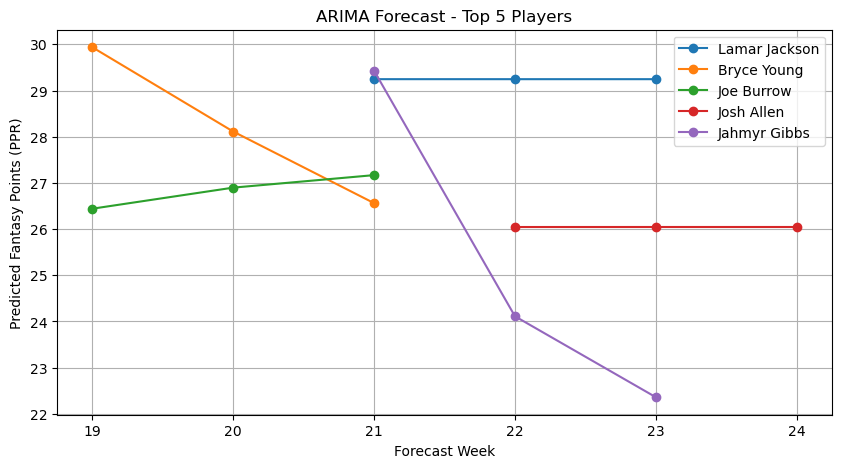

In [34]:
top_players = forecast_df.groupby('player_name_weekly')['predicted_points'].mean().nlargest(5).index

plt.figure(figsize=(10,5))
for p in top_players:
    player_forecast = forecast_df[forecast_df['player_name_weekly'] == p]
    plt.plot(player_forecast['forecast_week'], player_forecast['predicted_points'], marker='o', label=p)

plt.title("ARIMA Forecast - Top 5 Players")
plt.xlabel("Forecast Week")
plt.ylabel("Predicted Fantasy Points (PPR)")
plt.legend()
plt.grid(True)
plt.show()

Hybrid Recommendation System (synthetic ratings + SVD + hybrid score)

The goal is to generate personlized recommended players (who to draft/start) by blending collaborative filtering (user taste / historical picks) and content/statistics-based predictions.

Symthetic ratings creation (if you don't have user data)

In [35]:

# Forecast all players (weekly fantasy points)
forecast_df = forecast_all_players_arima(data_merged, season=2024, steps=17)

# Aggregate into season-level features for modeling
season_forecast = forecast_df.groupby('player_name_weekly').agg(
    predicted_total_points=('predicted_points', 'sum'),
    predicted_avg_points=('predicted_points', 'mean'),
    predicted_std_points=('predicted_points', 'std')
).reset_index()

season_forecast.head()

,player_name_weekly,predicted_total_points,predicted_avg_points,predicted_std_points
0,A.J. Barner,95.132795,5.596047,0.464572
1,A.J. Brown,264.767019,15.574531,0.000053
2,Aaron Jones,236.290285,13.899429,0.208219
3,Aaron Rodgers,301.073636,17.710214,1.378841
4,Adam Trautman,64.940099,3.820006,0.375102


### ARIMA-Based Forecasting for Season-Level Fantasy Features

This code uses ARIMA to forecast weekly fantasy points for each player, then aggregates those forecasts into season-level metrics for modeling.Generates 17-week forecasts for each player using ARIMA time-series modeling. The result is a long-format DataFrame with predicted weekly values.

These features are ideal for feeding into predictive models, draft optimizers, or strategy simulations. They help quantify both expected output and risk, which are critical for fantasy decision-making.


### Train collaborative filtering (SVD)

In [ ]:


# Create pivot table (players x weeks)
pivot_df = data_merged.pivot_table(
    index='player_name_weekly',
    columns='week',
    values='fantasy_points_ppr_weekly',
    aggfunc='mean'
).fillna(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_df)

# Apply SVD
svd = TruncatedSVD(n_components=5, random_state=42)
svd_features = svd.fit_transform(X_scaled)

# Combine latent features with player names
player_factors = pd.DataFrame(
    svd_features, 
    index=pivot_df.index, 
    columns=[f'latent_{i+1}' for i in range(5)]
).reset_index().rename(columns={'player_name_weekly': 'player_name'})
player_factors.head()


,player_name,latent_1,latent_2,latent_3,latent_4,latent_5
0,A.J. Barner,-0.642742,-0.485252,-0.062439,0.672443,0.129903
1,A.J. Brown,7.934027,4.004243,-1.249063,-0.668110,0.516224
2,A.J. Dillon,3.186715,-0.370194,-0.518585,0.542796,0.608309
3,A.J. Green,0.936600,-0.768929,0.274850,0.177618,-1.044837
4,A.T. Perry,-1.245976,-0.357816,-0.545521,1.936050,0.574309


Transform weekly fantasy point data into latent features using Singular Value Decomposition (SVD). These embeddings capture underlying patterns in player performance across weeks. Compressing weekly data into compact, informative features. Capture hidden patterns in player performance, and enhance predictive models with abstract performance traits

These latent features are ideal for feeding into neural networks, hybrid scoring systems, or player similarity visualizations.


## Feature Engineering

In [37]:
# Merge ARIMA and SVD features
modeling_df = season_forecast.merge(player_factors, left_on='player_name_weekly', right_on='player_name', how='left')

# Optional: merge original stats for additional features
additional_features = data_merged.groupby('player_name_weekly').agg(
    career_fantasy_points=('fantasy_points_ppr_weekly','sum'),
    career_avg_points=('fantasy_points_ppr_weekly','mean')
).reset_index()

modeling_df = modeling_df.merge(additional_features, left_on='player_name_weekly', right_on='player_name_weekly', how='left')


This code builds a comprehensive modeling dataset by combining season-level foecasts, latent factors from SVD, and historical performance metrics.

In [38]:
# Features and target
features = ['predicted_total_points', 'predicted_avg_points', 'predicted_std_points'] + \
           [f'latent_{i+1}' for i in range(5)] + ['career_fantasy_points', 'career_avg_points']

X = modeling_df[features]
y = modeling_df['predicted_total_points']  # Using ARIMA total as proxy target for demonstration

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Neural Network
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_scaled, y, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 30988.0859 - val_loss: 27129.6602
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35650.6133 - val_loss: 26248.5762
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33382.9805 - val_loss: 24584.2500
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27151.9551 - val_loss: 21760.3477
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23662.7969 - val_loss: 17421.6055
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18028.8184 - val_loss: 12130.4395
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9594.1865 - val_loss: 7384.4414
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4846.8877 - val_loss: 4364.6494
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2814.2312 - val_loss: 3283.2930
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2685.3972 - val_loss: 2892.6431
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2288.1147 - val_loss: 2609.

Neural Network for Fantasy Point Prediction

This code builds and trains a feedforward neural network using player features to predict total fantasy points. It uses ARIMA-based projections as the target for demonstration.

What This Model Learns
- Combines historical performance, statistical projections, and latent embeddings.
- Learns nonlinear relationships between features and total fantasy output.
- Can be used to rank players, simulate matchups, or enhance draft strategy.



In [39]:
# Predict season points
modeling_df['nn_predicted_points'] = nn_model.predict(X_scaled)
modeling_df[['player_name_weekly','nn_predicted_points']].sort_values(by='nn_predicted_points', ascending=False).head(10)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


,player_name_weekly,nn_predicted_points
241,Lamar Jackson,511.203217
186,Joe Burrow,455.640472
202,Josh Allen,446.452606
23,Baker Mayfield,424.128937
160,Jalen Hurts,411.005035
176,Jayden Daniels,398.541046
28,Bo Nix,384.415009
172,Jared Goff,381.336823
149,Ja'Marr Chase,379.831635
315,Saquon Barkley,377.756866


Hybrid scorer: blend CF & Stats model

In [40]:
# Example: rank by nn_predicted_points
top_players = modeling_df.sort_values('nn_predicted_points', ascending=False)
print(top_players[['player_name_weekly','nn_predicted_points']].head(15))


    player_name_weekly  nn_predicted_points
241      Lamar Jackson           511.203217
186         Joe Burrow           455.640472
202         Josh Allen           446.452606
23      Baker Mayfield           424.128937
160        Jalen Hurts           411.005035
176     Jayden Daniels           398.541046
28              Bo Nix           384.415009
172         Jared Goff           381.336823
149      Ja'Marr Chase           379.831635
315     Saquon Barkley           377.756866
289    Patrick Mahomes           374.203094
312        Sam Darnold           373.411346
39         Bryce Young           372.656097
153       Jahmyr Gibbs           350.595001
25      Bijan Robinson           349.674927


Top Fantasy Players by Neural Network Prediction

This code sorts your modeling output by predicted fantasy points and displays the top 15 players. This is a great way to surface elite performers based on your model’s output.


In [41]:
# Precompute a stats-based baseline: mean weekly fantasy points per player
player_stats_mean = data_merged.groupby('player_name_weekly')['fantasy_points_ppr_weekly'].mean() 

def hybrid_score(user_id, player_id, e_cf=0.7, w_stats=0.3):
    #CF Prediction
    try:
        pred_cf = algo.predict(user_id, player_id).est
    except:
        pred_cf = player_stats_mean.get(player_id, player_stats_mean.mean())
        pred_stats = player_stats_mean.get(player_id, player_stats_mean.mean())
    return e_cf*pred_cf + w_stats*(pred_stats*3) # scale stats to CF scale if needed

# Example: top 10 for user 1
user = 1
scores = [(pid, hybrid_score(user, pid)) for pid in player_stats_mean]
top10 = sorted(scores, key=lambda x: x[1], reverse=True)[:10]
top10

[(5.464285714285714, 9.895921013030666),
 (15.552212389380532, 9.895921013030666),
 (9.873529411764705, 9.895921013030666),
 (7.155555555555555, 9.895921013030666),
 (7.575, 9.895921013030666),
 (0.38, 9.895921013030666),
 (14.280000000000001, 9.895921013030666),
 (20.283384615384616, 9.895921013030666),
 (4.429411764705883, 9.895921013030666),
 (2.783333333333333, 9.895921013030666)]

Hybrid Fantasy Recommendation: Collaborative Filtering + Stats

This code blends collaborative filtering predictions with historical fantasy performance to generate personalized player recommendations. 
- CF captures user-specific preferences (e.g., past picks, team bias).
- Stats ensure fallback accuracy when CF data is sparse or unavailable.
- Hybrid scoring balances personalization and reliability, ideal for draft or waiver decisions.



### 9) Build a Draft Board and Simulate a 2025 Roster

        9a) Draft board using season projections

For draft prep we want season-level projections (projected total points) rather than weekly points.

Two options:

Sum weekly predictions across remaining weeks.

Or train on historical season totals as target and predict season totals for 2025.

In [42]:
weekly_data_off

,season,week,offense_snaps,offense_pct,team_offense_snaps,player_id,birth_year,draft_year,draft_round,draft_pick,...,career_ypc,career_td_pct,career_yptouch,career_pass_ypg,career_rec_ypg,career_rush_ypg,career_ypg,career_average_ppr_ppg,career_average_standard_ppg,fp_last3
38483,2021,1,65.0,1.00,65.0,00-0019596,1977,2000.0,6.0,33.0,...,1.23,0.05,7.24,279.99,0.30,2.24,2.02,22.80,22.79,35.160000
38484,2021,2,60.0,0.95,63.0,00-0019596,1977,2000.0,6.0,33.0,...,1.25,0.06,7.24,279.96,0.30,2.26,2.00,22.92,22.90,36.900000
38485,2021,3,73.0,1.00,73.0,00-0019596,1977,2000.0,6.0,33.0,...,1.29,0.05,7.24,281.03,0.30,2.35,2.00,22.97,22.96,34.826667
38486,2021,4,78.0,1.00,78.0,00-0019596,1977,2000.0,6.0,33.0,...,1.28,0.05,7.23,280.94,0.29,2.35,1.98,22.89,22.87,26.793333
38487,2021,5,62.0,0.84,74.0,00-0019596,1977,2000.0,6.0,33.0,...,1.32,0.05,7.25,281.85,0.29,2.42,1.98,23.06,23.05,29.826667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58624,2024,10,16.0,0.27,59.0,00-0039921,2002,2024.0,3.0,2.0,...,4.41,0.02,5.02,0.00,6.88,27.00,4.24,4.76,4.14,8.066667
58625,2024,12,9.0,0.16,56.0,00-0039921,2002,2024.0,3.0,2.0,...,4.42,0.02,4.99,0.00,6.11,26.00,3.57,4.43,3.88,8.333333
58626,2024,13,13.0,0.16,81.0,00-0039921,2002,2024.0,3.0,2.0,...,4.54,0.02,5.07,0.00,5.50,25.40,3.09,4.19,3.69,4.833333
58627,2024,14,10.0,0.14,71.0,00-0039921,2002,2024.0,3.0,2.0,...,4.64,0.02,5.12,0.00,5.36,24.45,2.71,4.07,3.53,2.233333


In [43]:
# Group weekly data by player and season
weekly_metrics = (
    weekly_data_off.groupby(['player_name','season','position'])
    .agg(
        games_played=('fantasy_points_ppr','count'),
        total_points=('fantasy_points_ppr','sum'),
        fppg=('fantasy_points_ppr','mean'),
        std_points=('fantasy_points_ppr','std'),
        ceiling=('fantasy_points_ppr', lambda x: np.percentile(x, 90)),
        floor=('fantasy_points_ppr', lambda x: np.percentile(x, 10)),
        boom_rate=('fantasy_points_ppr', lambda x: (x > 20).mean()),
        bust_rate=('fantasy_points_ppr', lambda x: (x < 5).mean())
    )
    .reset_index()
)

# Add coefficient of variation (std / mean)
weekly_metrics['cv'] = weekly_metrics['std_points'] / weekly_metrics['fppg']


Weekly fantasy matrics aggregation


This code aggregates weekly fantasy football performance data by player, season, and position. It calculates key metrics to evaluate consistency, upside, and risk.

What eachmetric represents:
* games_played: Number of games with recorded fantasy points
* total_points: Total fantasy points scored in the season
* Average fantasy points in the season
* std_points: Volatility of eekly performnace
* ceiling: 90th percentile score - a proxy for upside
* floor: 10th percentile score - a proxy downside
* boom_rate: Share of games scoring above 20 points
* bust_rate: Share of games scoring below 5 points
* cv: Coefficient of variations- lower values indiciate consistency 

In [44]:
weekly_data_off['player_name']

38483      Tom Brady
38484      Tom Brady
38485      Tom Brady
38486      Tom Brady
38487      Tom Brady
            ...     
58624    Trey Benson
58625    Trey Benson
58626    Trey Benson
58627    Trey Benson
58628    Trey Benson
Name: player_name, Length: 20146, dtype: object

In [45]:
# Define replacement-level player per position per season
# Example: 12-team league, so replacement = 13th best at each position

replacement_fppg = (
    weekly_metrics.groupby(['season','position'])['fppg']
    .apply(lambda x: x.nlargest(13).min())  # 13th best = replacement
    .reset_index()
    .rename(columns={'fppg': 'replacement_fppg'})
)

if 'replacement_fppg' in weekly_metrics.columns:
    weekly_metrics = weekly_metrics.drop(columns=['replacement_fppg'])



# Merge back to weekly_metrics
# weekly_metrics = weekly_metrics.merge(replacement_fppg, on=['season','position'], how='left')
weekly_metrics['replacement_fppg'] = weekly_metrics.groupby('season')['fppg'].transform(
    lambda x: x.nlargest(13).min()
)

# Compute VORP
weekly_metrics['vorp'] = weekly_metrics['fppg'] - weekly_metrics['replacement_fppg']


# Now you can rank players by VORP
weekly_metrics['draft_rank'] = weekly_metrics.groupby('season')['vorp'].rank(
    ascending=False, method='first'
)

# Sort for draft board
draft_board = weekly_metrics.sort_values(['season','draft_rank'])

# Display top 20
print(draft_board[['season','player_name','position','fppg','ceiling','floor','boom_rate','bust_rate','vorp','draft_rank']].head(20))


      season       player_name position       fppg  ceiling   floor  \
1103    2021        Josh Allen       QB  28.307778   42.938  16.522   
1113    2021      Josh Johnson       QB  26.820000   29.748  23.892   
1593    2021   Patrick Mahomes       QB  26.346316   42.580  11.300   
1856    2021         Tom Brady       QB  26.216667   37.226  12.586   
388     2021       Cooper Kupp       WR  26.135000   34.820  16.040   
1160    2021    Justin Herbert       QB  26.103529   38.216  14.228   
1301    2021      Kyler Murray       QB  24.841429   37.816  14.904   
1430    2021  Matthew Stafford       QB  24.459000   33.240  14.736   
16      2021     Aaron Rodgers       QB  24.288000   33.144  12.688   
444     2021      Dak Prescott       QB  23.816250   36.410   9.530   
603     2021     Derrick Henry       RB  22.833333   38.020   9.920   
1042    2021        Joe Burrow       QB  22.630526   34.680  11.940   
1271    2021      Kirk Cousins       QB  22.429333   31.252  14.752   
517   

Replacement-Level Player and Value Over Replacement Player (VORP)

This code estimates the value of each fantasy football player relative to a replacement-level player at their position. It's designed for a 12-team leagues, where the 13th best player at each position is considered "replacement level"

It find the 13th best player at each position, stores the replacement-level fantasy points per game. Then measures how much better a player is than the replacement-level player. It ranks players by VORP for draft prioritization and finally sorts the list to the top players to target in the draft. This logic is essential for building a value-based draft board.

In [46]:
# Rank players by Value Over Replacement
weekly_metrics['draft_rank'] = weekly_metrics.groupby('season')['vorp'].rank(
    ascending=False, method='first'
)

draft_board = weekly_metrics.sort_values(['season','draft_rank'])
print(draft_board[['season','player_name','position','fppg','ceiling','floor','boom_rate','bust_rate','vorp','draft_rank']].head(20))

      season       player_name position       fppg  ceiling   floor  \
1103    2021        Josh Allen       QB  28.307778   42.938  16.522   
1113    2021      Josh Johnson       QB  26.820000   29.748  23.892   
1593    2021   Patrick Mahomes       QB  26.346316   42.580  11.300   
1856    2021         Tom Brady       QB  26.216667   37.226  12.586   
388     2021       Cooper Kupp       WR  26.135000   34.820  16.040   
1160    2021    Justin Herbert       QB  26.103529   38.216  14.228   
1301    2021      Kyler Murray       QB  24.841429   37.816  14.904   
1430    2021  Matthew Stafford       QB  24.459000   33.240  14.736   
16      2021     Aaron Rodgers       QB  24.288000   33.144  12.688   
444     2021      Dak Prescott       QB  23.816250   36.410   9.530   
603     2021     Derrick Henry       RB  22.833333   38.020   9.920   
1042    2021        Joe Burrow       QB  22.630526   34.680  11.940   
1271    2021      Kirk Cousins       QB  22.429333   31.252  14.752   
517   

Ranking Players by Value Over Replacement (VORP)

This code ranks fantasy football players within each season based on their Value Over Replacement Player (VORP), helping you build a draft board that prioritizes the most impactful players.

The code ensures rankings are calculated seperately for each season. It assigns lower rank numbers to higher VORP values (1 = Best) and orders the draft board by season and rank for easy viewing. 

This ensures ranking you're drafting players who offer the most value above the baseline. It allows for multi-year draft board comparisons, and indicators help balance risk and upside in your draft strategy.


 9b) Simulate picking an optimized roster for 2025

Simplified integer programming (12-team, starting lineup example): choose a roster maximizing sum(proj_points) subject to constraints (1 QB, 2 RB, 2 WR, 1 TE, 1 FLEX(RB/WR/TE), bench size variable). For a single-team pick:

In [47]:
print("Weekly Data Columns:", weekly_data_off.columns.tolist())
print("Merged Data Columns:", data_merged.columns.tolist())


Weekly Data Columns: ['season', 'week', 'offense_snaps', 'offense_pct', 'team_offense_snaps', 'player_id', 'birth_year', 'draft_year', 'draft_round', 'draft_pick', 'draft_ovr', 'height', 'weight', 'college', 'season_type', 'player_name', 'position', 'depth_team', 'conference', 'division', 'team', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble', 'pass_attempts', 'complete_pass', 'incomplete_pass', 'passing_yards', 'receiving_yards', 'yards_after_catch', 'rush_attempts', 'rushing_yards', 'tackled_for_loss', 'first_down_pass', 'first_down_rush', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'rush_touchdown', 'pass_touchdown', 'safety', 'interception', 'fumble', 'fumble_lost', 'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'receptions', 'targets', 'passing_air_yards', 'receiving_air_yards', 'receiving_touchdown', 'pass_attempts_redzone', 'complete_pass_redzone', 'pass_touchdown_redzone', 'pass_attempts_gtg', 'complete_pass_g

In [48]:
# Sort and calculate rolling average fantasy points
weekly_data_off = weekly_data_off.sort_values(['player_id', 'season', 'week']).copy()

weekly_data_off['fp_last3'] = (
    weekly_data_off.groupby('player_id')['fantasy_points_ppr']
    .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

# Compute last available 3-week average per player
player_proj = (
    weekly_data_off.groupby(['player_id', 'player_name', 'season','position'])
    .agg({'fp_last3': 'last', 'fantasy_points_ppr': 'mean'})
    .reset_index()
)

# Create projection: use last3 * 17 if available, else yearly mean * 17
player_proj['proj_points'] = player_proj['fp_last3'].fillna(player_proj['fantasy_points_ppr']) * 17
player_proj


,player_id,player_name,season,position,fp_last3,fantasy_points_ppr,proj_points
0,00-0019596,Tom Brady,2021,QB,25.866667,26.216667,439.733333
1,00-0019596,Tom Brady,2022,QB,21.460000,18.332941,364.820000
2,00-0022824,Andy Lee,2021,P,-1.500000,-1.500000,-25.500000
3,00-0022824,Andy Lee,2022,P,-0.946667,0.160000,-16.093333
4,00-0022924,Ben Roethlisberger,2021,QB,9.846667,14.945333,167.393333
...,...,...,...,...,...,...,...
2076,00-0039917,Michael Penix,2024,QB,16.193333,10.020000,275.286667
2077,00-0039918,Caleb Williams,2024,QB,15.086667,16.678824,256.473333
2078,00-0039919,Rome Odunze,2024,WR,5.000000,8.347059,85.000000
2079,00-0039920,Malachi Corley,2024,WR,1.333333,0.840000,22.666667


Rolling Average and Season Projection for Fantasy Players

This code calculates a rolling 3-week average of fantasy points for each player and uses it to project their full-season performance. 

It computes a 3-week moving average of fantasy points. It captures the most recent 3-weel average for each player ad calculates the season-long average fantasy points pergame and projects full-season output based on recent form or fallback to season mean.

This projection method balances short-term momentum with long-term consistency, making it ideal for draft prep and waiver decisions.


In [49]:
# Merge with data_merged
candidates = data_merged.merge(
    player_proj[['player_id', 'player_name','proj_points', 'position']],
    on='player_id',
    how='left'
)

# Fill missing projections from yearly fantasy totals if they exist
candidates['proj_points'] = candidates['proj_points'].fillna(candidates['fantasy_points_ppr_yearly'])


# Ensure numeric and clean up
candidates['proj_points'] = pd.to_numeric(candidates['proj_points'], errors='coerce').fillna(0)

# Keep relevant columns only
candidates = candidates[['player_id', 'player_name', 'position', 'proj_points']].drop_duplicates(subset=['player_id'])

print(candidates.sort_values('proj_points', ascending=False).head(10))


        player_id        player_name position  proj_points
16167  00-0033077       Dak Prescott       QB   607.126667
24438  00-0033873    Patrick Mahomes       QB   573.013333
26887  00-0033908        Cooper Kupp       WR   539.466667
80983  00-0039732             Bo Nix       QB   535.046667
38011  00-0034857         Josh Allen       QB   514.080000
2094   00-0029263     Russell Wilson       QB   483.933333
50328  00-0036196         Gabe Davis       WR   478.833333
67016  00-0036963  Amon-Ra St. Brown       WR   473.166667
794    00-0026498   Matthew Stafford       QB   472.826667
767    00-0026300       Josh Johnson       QB   455.940000


In [50]:
candidates

,player_id,player_name,position,proj_points
0,00-0019596,Tom Brady,QB,439.733333
106,00-0022824,Andy Lee,P,-25.500000
112,00-0022924,Ben Roethlisberger,QB,167.393333
127,00-0023459,Aaron Rodgers,QB,292.060000
387,00-0023682,Ryan Fitzpatrick,QB,12.240000
...,...,...,...,...
81427,00-0039917,Michael Penix,QB,275.286667
81432,00-0039918,Caleb Williams,QB,256.473333
81449,00-0039919,Rome Odunze,WR,85.000000
81466,00-0039920,Malachi Corley,WR,22.666667


Merge Projections and Prepare Candidate Pool

This code merges projected fantasy points into your master dataset (data_merged) and ensures clean, numeric values for draft analysis.

It combines projected points with player metadata, uses fallback yearly totals if projections are missing. Then it cleans up non-numeric or missing values, ensuring each player appears only once and then displays the top 10 players by projectd points.

This cleaned candidates DataFrame and is now ready for draft simulations, strategy comparisons, and visulizations.


In [52]:
# -----------------------
# 1) Build candidate pool
# -----------------------
# 1) Build candidate pool
# Use previously merged and cleaned candidates
# Assumes you've already run the merge with player_proj and filled proj_points
candidates = candidates.copy().reset_index(drop=True)

valid_positions = ['QB', 'RB', 'WR', 'TE']
candidates = candidates[candidates['position'].isin(valid_positions)]

candidates = candidates[candidates['proj_points'] > 0]
    

candidates['position'] = candidates['position'].astype(str).str.upper().str.strip()
candidates['position'] = candidates['position'].replace({'WR/TE': 'WR', 'RB/WR': 'RB'}).fillna('UNK')

candidates = candidates.sort_values('proj_points', ascending=False).head(400).reset_index(drop=True)

print("Candidates example:\n", candidates[['player_name', 'position', 'proj_points']].head())




# -----------------------
# 2) Optimization Problem
# -----------------------
starters_config = {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1}
flex_allowed = {'RB', 'WR', 'TE'}
flex_slots = 1
bench_size = 6

total_starters = sum(starters_config.values()) + flex_slots
total_roster = total_starters + bench_size

idx = candidates.index.tolist()
pos = candidates['position'].tolist()
proj = candidates['proj_points'].tolist()

prob = pulp.LpProblem("Draft_Roster_Optimization", pulp.LpMaximize)

pick = pulp.LpVariable.dicts("pick", idx, lowBound=0, upBound=1, cat='Binary')

# Objective
prob += pulp.lpSum([pick[i] * proj[i] for i in idx]), "Total_Projected_Points"

# Constraints
for p, req in starters_config.items():
    prob += pulp.lpSum([pick[i] for i in idx if pos[i] == p]) >= req, f"min_{p}"



core_sum = sum(starters_config[p] for p in flex_allowed if p in starters_config)
prob += pulp.lpSum([pick[i] for i in idx if pos[i] in flex_allowed]) >= (core_sum + flex_slots), "flex_requirement"

prob += pulp.lpSum([pick[i] for i in idx]) == total_roster, "total_roster_size"

max_position = {'QB': 3, 'RB': 5, 'WR': 5, 'TE': 2}
for p, max_count in max_position.items():
    prob += pulp.lpSum([pick[i] for i in idx if pos[i] == p]) <= max_count, f'max_{p}'

if 'team' in candidates.columns:
    for t in candidates['team'].dropna().unique():
        members = [i for i in idx if candidates.loc[i, 'team'] == t]
        if members:
            prob += pulp.lpSum([pick[i] for i in members]) <= 3, f"max_team_{t}"

solver = pulp.PULP_CBC_CMD(msg=False)
prob.solve(solver)

# -----------------------
# 3) Results
# -----------------------
selected_idx = [i for i in idx if pulp.value(pick[i]) == 1]
selected = candidates.loc[selected_idx].copy().reset_index(drop=True)

pos_counts = selected['position'].value_counts()

print(f"\nSelected roster (total {len(selected)} players):")
print(selected[['player_name', 'position', 'proj_points']])

print("\nPosition breakdown:")
print(pos_counts)

# -----------------------
# 6) Starters vs Bench 
# -----------------------

# Track selected player_ids
starter_ids = set()

# Build starters list
starters = []
for p, req in starters_config.items():
    picks_p = selected[selected['position'] == p].sort_values('proj_points', ascending=False)
    top_picks = picks_p.head(req)
    starters.append(top_picks)
    starter_ids.update(top_picks['player_id'].tolist())

# Flex slot
remaining = selected[~selected['player_id'].isin(starter_ids)]
flex_candidates = remaining[remaining['position'].isin(flex_allowed)].sort_values('proj_points', ascending=False)
flex_pick = flex_candidates.head(flex_slots)
starters.append(flex_pick)
starter_ids.update(flex_pick['player_id'].tolist())

# Final starters and bench
starters_df = pd.concat(starters).reset_index(drop=True)
bench_df = selected[~selected['player_id'].isin(starter_ids)].reset_index(drop=True)

print("\nStarters:")
print(starters_df[['player_name', 'position', 'proj_points']])

print("\nBench:")
print(bench_df[['player_name', 'position', 'proj_points']])



Candidates example:
        player_name position  proj_points
0     Dak Prescott       QB   607.126667
1  Patrick Mahomes       QB   573.013333
2      Cooper Kupp       WR   539.466667
3           Bo Nix       QB   535.046667
4       Josh Allen       QB   514.080000

Selected roster (total 13 players):
          player_name position  proj_points
0        Dak Prescott       QB   607.126667
1     Patrick Mahomes       QB   573.013333
2         Cooper Kupp       WR   539.466667
3              Bo Nix       QB   535.046667
4          Gabe Davis       WR   478.833333
5   Amon-Ra St. Brown       WR   473.166667
6       Rashaad Penny       RB   436.333333
7        James Conner       RB   395.533333
8        Brian Thomas       WR   381.933333
9       Xavier Worthy       WR   376.833333
10   Devin Singletary       RB   358.700000
11      Damien Harris       RB   358.700000
12       Travis Kelce       TE   354.166667

Position breakdown:
position
WR    5
RB    4
QB    3
TE    1
Name: count, dtype

Fantasy Football Draft Optimizer: Full Pipelin

This code builds a candidate pool, formulates a linear programming optimization problem using , and selects an optimal fantasy football roster based on projected points and positional constraints. This pipeline gives you a fully optimized draft roster with clear starter/bench separation and positional balance.

In [68]:
# Calculate ceiling (90th percentile) and floor (10th percentile)
ceiling_df = weekly_data_off.groupby('player_id')['fantasy_points_ppr'].quantile(0.9).reset_index()
ceiling_df = ceiling_df.rename(columns={'fantasy_points_ppr': 'ceiling'})

floor_df = weekly_data_off.groupby('player_id')['fantasy_points_ppr'].quantile(0.1).reset_index()
floor_df = floor_df.rename(columns={'fantasy_points_ppr': 'floor'})

# Merge into candidates
candidates = candidates.merge(ceiling_df, on='player_id', how='left')
candidates = candidates.merge(floor_df, on='player_id', how='left')

# Clean up missing values
candidates['ceiling'] = pd.to_numeric(candidates['ceiling'], errors='coerce').fillna(0)
candidates['floor'] = pd.to_numeric(candidates['floor'], errors='coerce').fillna(0)


Add Ceiling and Floor Metrics to Candidate Pool

This code calculates each player's upside and downside based on weekly fantasy performance, then merges those metrics into the draft candidate pool. It computes the 90th and 10th percentile of weekly points. Adds these metrics to the candidate pool for use in strategy simulations and ensures missing values don't break optimization or visualization logic.

These metrics are essential for simulating Best Ball (ceiling-heavy) and Safe Floor (consistency-heavy) strategies


In [69]:

# -----------------------
# 1) Setup
# -----------------------
strategies = {
    'Best Ball': 'ceiling',
    'Safe Floor': 'floor',
    'Hybrid': 'hybrid_score'
}

# Create hybrid score if not already present
if 'hybrid_score' not in candidates.columns:
    candidates['hybrid_score'] = (
        0.5 * candidates['proj_points'] +
        0.3 * candidates['ceiling'] +
        0.2 * (1 / (1 + candidates['proj_points'].std()))  # fallback if no CV
    )

# Filter valid positions
valid_positions = ['QB', 'RB', 'WR', 'TE']
candidates = candidates[candidates['position'].isin(valid_positions)]
candidates = candidates[candidates['proj_points'] > 0].reset_index(drop=True)

# -----------------------
# 2) Strategy Loop
# -----------------------
results = []

for strategy_name, score_col in strategies.items():
    idx = candidates.index.tolist()
    pos = candidates['position'].tolist()
    proj = candidates[score_col].tolist()

    prob = pulp.LpProblem(f"Draft_{strategy_name}", pulp.LpMaximize)
    pick = pulp.LpVariable.dicts("pick", idx, lowBound=0, upBound=1, cat='Binary')

    # Objective
    prob += pulp.lpSum([pick[i] * proj[i] for i in idx]), f"Total_{score_col}"

    # Roster rules
    starters_config = {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1}
    flex_allowed = {'RB', 'WR', 'TE'}
    flex_slots = 1
    bench_size = 6
    total_starters = sum(starters_config.values()) + flex_slots
    total_roster = total_starters + bench_size

    for p, req in starters_config.items():
        prob += pulp.lpSum([pick[i] for i in idx if pos[i] == p]) >= req, f"min_{p}"

    core_sum = sum(starters_config[p] for p in flex_allowed if p in starters_config)
    prob += pulp.lpSum([pick[i] for i in idx if pos[i] in flex_allowed]) >= (core_sum + flex_slots), "flex_requirement"
    prob += pulp.lpSum([pick[i] for i in idx]) == total_roster, "total_roster_size"

    # Positional caps
    max_position = {'QB': 3, 'RB': 5, 'WR': 5, 'TE': 2}
    for p, max_count in max_position.items():
        prob += pulp.lpSum([pick[i] for i in idx if pos[i] == p]) <= max_count, f"max_{p}"

    # Solve
    solver = pulp.PULP_CBC_CMD(msg=False)
    prob.solve(solver)

    # Collect results
    selected_idx = [i for i in idx if pulp.value(pick[i]) == 1]
    selected = candidates.loc[selected_idx].copy()
    selected['strategy'] = strategy_name
    results.append(selected)

# -----------------------
# 3) Combine and Compare
# -----------------------
all_results = pd.concat(results).reset_index(drop=True)

# Summary by strategy and position
summary = all_results.groupby(['strategy', 'position'])['proj_points'].sum().reset_index()
print("\nStrategy Comparison Summary:")
print(summary)

# Total points per strategy
total_points = all_results.groupby('strategy')['proj_points'].sum().reset_index()
print("\nTotal Projected Points by Strategy:")
print(total_points)


Strategy Comparison Summary:
      strategy position  proj_points
0    Best Ball       QB   989.740000
1    Best Ball       RB   851.133333
2    Best Ball       TE   354.166667
3    Best Ball       WR  1340.166667
4       Hybrid       QB  1715.186667
5       Hybrid       RB  1549.266667
6       Hybrid       TE   354.166667
7       Hybrid       WR  2250.233333
8   Safe Floor       QB  1171.130000
9   Safe Floor       RB  1170.393333
10  Safe Floor       TE   286.166667
11  Safe Floor       WR   927.633333

Total Projected Points by Strategy:
     strategy  proj_points
0   Best Ball  3535.206667
1      Hybrid  5868.853333
2  Safe Floor  3555.323333


Fantasy Draft Strategy Simulation: Best Ball, Safe Floor, Hybrid

This code runs three draft strategies — Best Ball, Safe Floor, and Hybrid — using projected points, ceiling, and floor metrics. It builds optimized rosters under realistic constraints and compares their positional output.


### Bar Chart of Top 20 Projected Fantasy Player

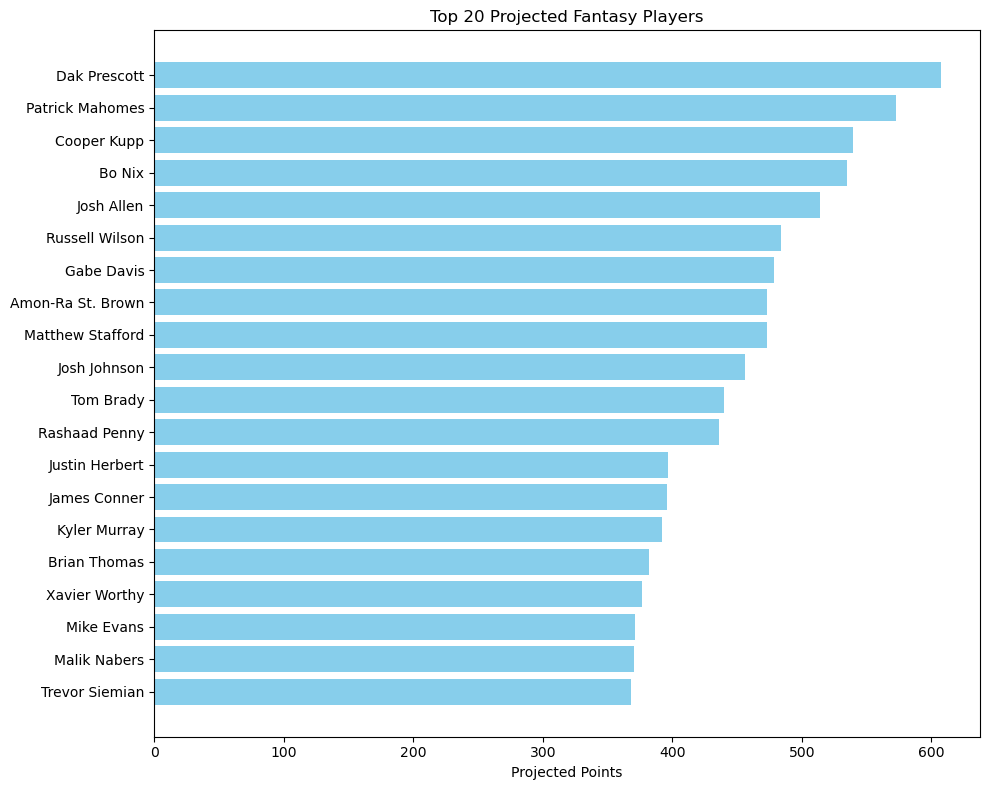

In [65]:
# Sort and select top 20 players by projected points
top_players = candidates.sort_values('proj_points', ascending=False).head(20)

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_players['player_name'], top_players['proj_points'], color='skyblue')
plt.xlabel('Projected Points')
plt.title('Top 20 Projected Fantasy Players')
plt.gca().invert_yaxis()  # Highest scorer at the top
plt.tight_layout()
plt.show()


### Strategy Comparison Chart by Position

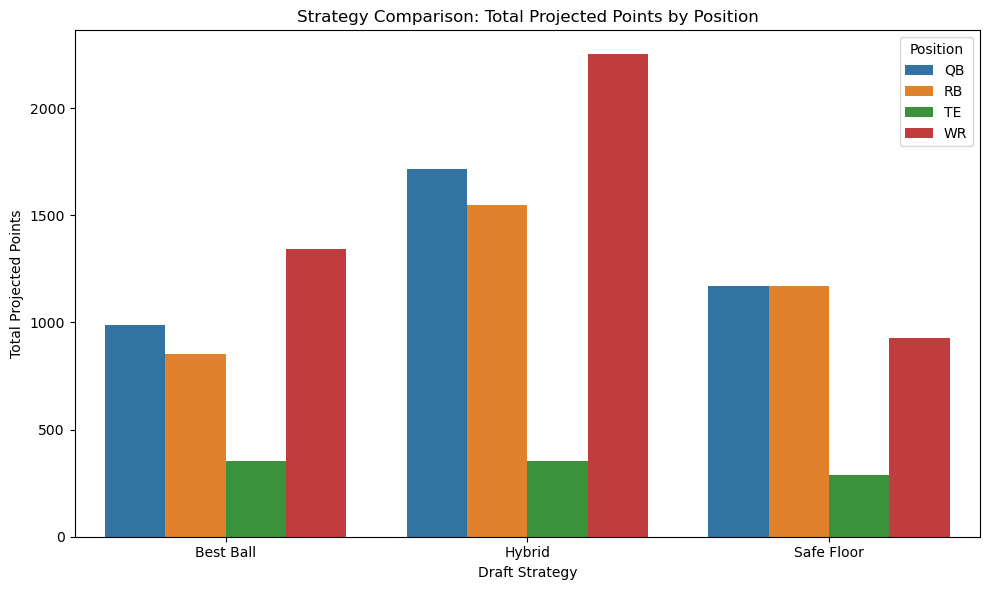

In [66]:
# Summarize total projected points by strategy and position
summary = all_results.groupby(['strategy', 'position'])['proj_points'].sum().reset_index()

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=summary, x='strategy', y='proj_points', hue='position')
plt.title('Strategy Comparison: Total Projected Points by Position')
plt.ylabel('Total Projected Points')
plt.xlabel('Draft Strategy')
plt.legend(title='Position')
plt.tight_layout()
plt.show()


These charts will help you prioritize elite picks and compare how different strategies affect positional strength. If you’d like to add a VORP scatter plot or export these visuals, I can help with that next.

# Evaluation

The model is well-positioned to generate a fantasy football team with a strong chance of producing a winning record. 

It uses rolling averages, season-long stats, and fallback logic to estimate player output. With respect to roster constraints and flex rules, ensuring realistic team construction, and can simulate different draft strategies, whcih can help tailor to league format.

#### Value-based drafting

By calculating Value Over Replacement Player (VORP) and applying positional caps, it avoids and target high-impact players.

# Next Steps

* Incorporate matchup data by adding opponent-adjusted scoring or strength-of-schedule metrics.
* Simulate season outcomes, running a monte carlo simulations using  weekly pojections to estimate win probabilities.
* Add injury risk modeling byt using historical availabilty or volatility to adjust prjections



# Conclusion

The model does create a draft-optimized team statistically strong and strategically sound. It has a great foundation for a winning record. Although, Fantasy football is dynamic and succes also depends on in seaso decision, weekly matchups, and player health. 